Częstotliwość próbkowania: 48000 Hz
Liczba kanałów:        1
► Czas trwania: 4.075 s


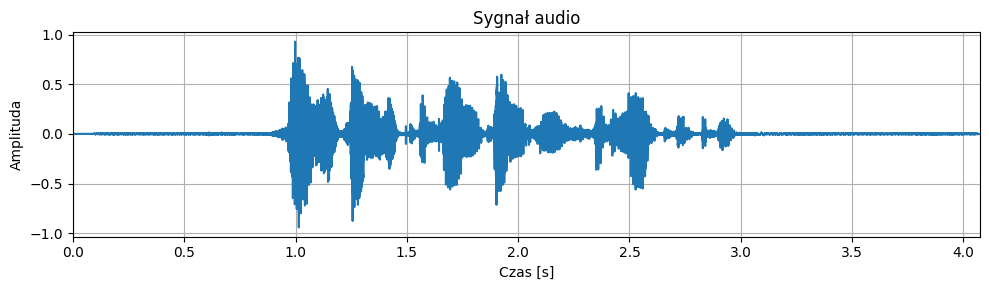

In [166]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt

file_path = './audio/audio_test.wav'

info = sf.info(file_path)
print(f"Częstotliwość próbkowania: {info.samplerate} Hz")
print(f"Liczba kanałów:        {info.channels}")

s, fs = sf.read(file_path, dtype='float32')
if s.ndim > 1:
    s = s[:, 0]

duration = len(s) / fs
print(f"► Czas trwania: {duration:.3f} s")

max_val = np.max(np.abs(s))
if max_val > 1:
    s = s / max_val

sd.play(s, fs)
sd.wait()

time = np.arange(len(s)) / fs
plt.figure(figsize=(10, 3))
plt.plot(time, s)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał audio')
plt.grid(True)
plt.xlim(0, duration)
plt.tight_layout()
plt.show()


srednia amp. szumu (poczatek) :  0.0011193239
srednia amp. szumu (koniec) :  0.001559762


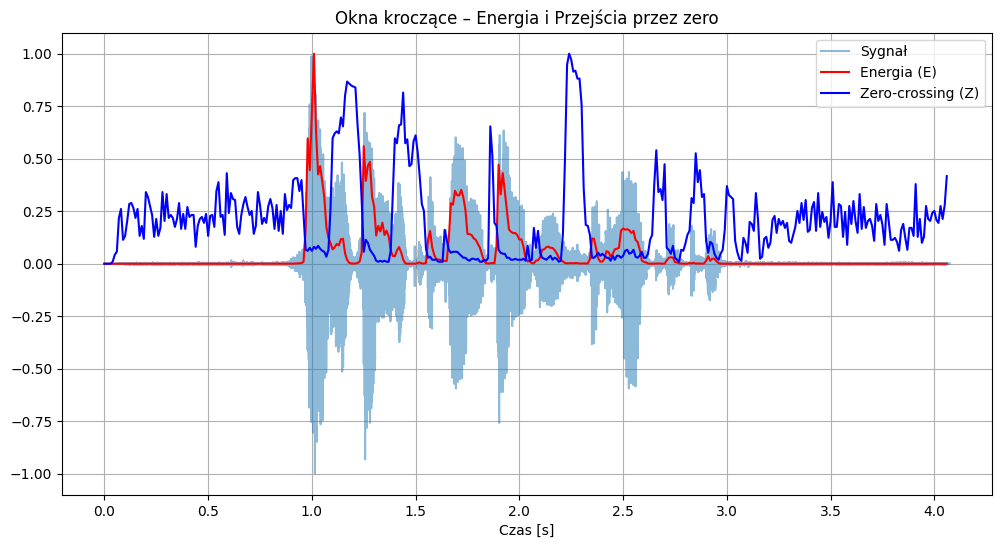

In [167]:
s = s / np.max(np.abs(s))
start = s[:int(0.5 * fs)]
end = s[-int(0.5 * fs):]

print("srednia amp. szumu (poczatek) : ", np.mean(np.abs(start)))
print("srednia amp. szumu (koniec) : ", (np.mean(np.abs(end))))

###### 2

import numpy as np
import matplotlib.pyplot as plt

frame_ms = 10
frame_len = int(fs * frame_ms / 1000)
num_frames = len(s) // frame_len

s_trimmed = s[:num_frames * frame_len]

frames = s_trimmed.reshape(num_frames, frame_len)

E = np.sum(frames**2, axis=1)
def zero_cross(frame):
    sum = 0
    for i in range(len(frame)-1):
        if frame[i] * frame[i+1] < 0:
            sum += 1
    return sum

Z = np.array([zero_cross(f) for f in frames])

E = E / np.max(E)
Z = Z / np.max(Z)

frame_times = np.arange(num_frames) * (frame_len / fs)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(s)) / fs, s, label='Sygnał', alpha=0.5)
plt.plot(frame_times, E, 'r-', label='Energia (E)')
plt.plot(frame_times, Z, 'b-', label='Zero-crossing (Z)')
plt.xlabel("Czas [s]")
plt.title("Okna kroczące – Energia i Przejścia przez zero")
plt.legend()
plt.grid(True)
plt.show()



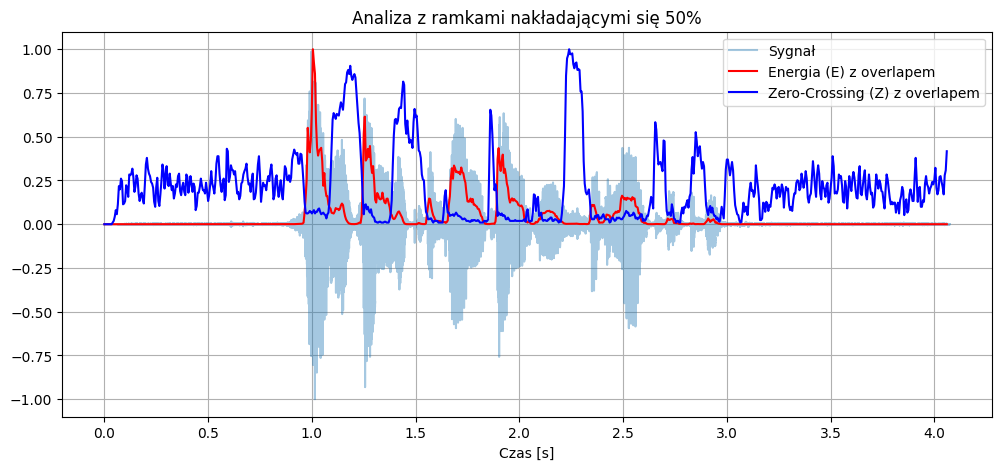

In [168]:
def calculate_overlap(signal, fs, frame_ms=10, overlap=0.5):
    frame_len = int(fs * frame_ms / 1000)
    hop_len = int(frame_len * (1 - overlap))
    num_frames = (len(signal) - frame_len) // hop_len + 1

    E = []
    Z = []
    times = []

    for i in range(num_frames):
        start = i * hop_len
        frame = signal[start:start + frame_len]
        energy = np.sum(frame ** 2)
        zero_crosses = zero_cross(frame)
        
        E.append(energy)
        Z.append(zero_crosses)
        times.append(start / fs)

    E = np.array(E) / np.max(E)
    Z = np.array(Z) / np.max(Z)

    return np.array(times), E, Z


t,E,Z = calculate_overlap(s,fs,frame_ms=10,overlap=0.5)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(s)) / fs, s, label='Sygnał', alpha=0.4)
plt.plot(t, E, 'r-', label='Energia (E) z overlapem')
plt.plot(t, Z, 'b-', label='Zero-Crossing (Z) z overlapem')
plt.xlabel("Czas [s]")
plt.title("Analiza z ramkami nakładającymi się 50%")
plt.legend()
plt.grid(True)
plt.show()

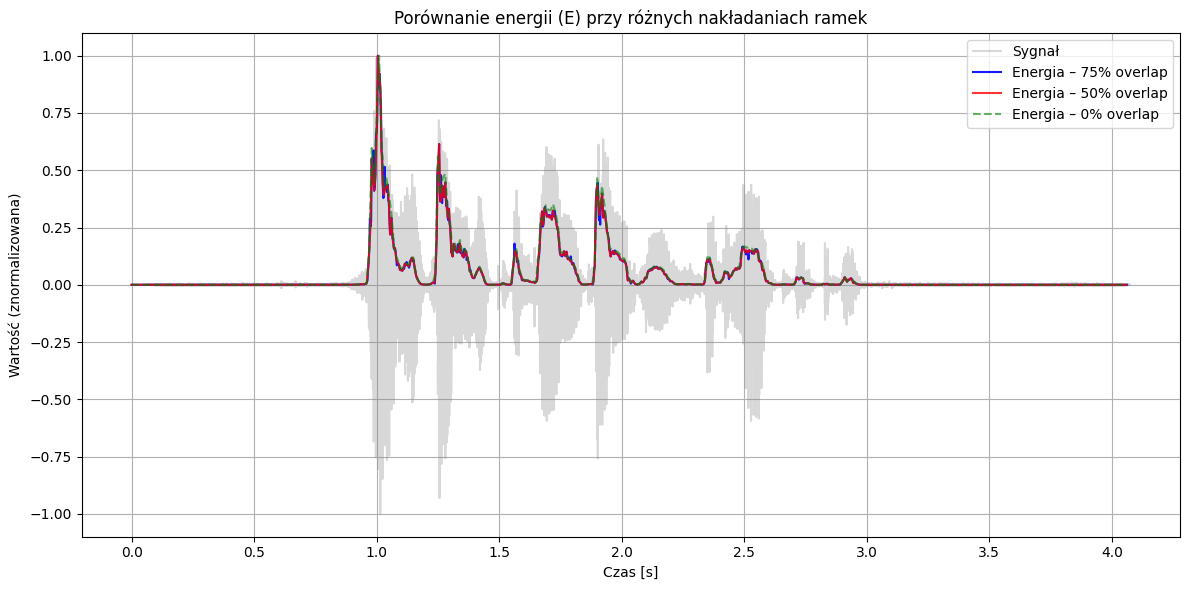

In [169]:
t1, E1, _ = calculate_overlap(s, fs, frame_ms=10, overlap=0.0)
t2, E2, _ = calculate_overlap(s, fs, frame_ms=10, overlap=0.5)
t3, E3, _ = calculate_overlap(s, fs, frame_ms=10, overlap=0.75)

plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(s)) / fs, s, color='gray', alpha=0.3, label='Sygnał')

plt.plot(t3, E3, 'b-', label="Energia – 75% overlap", alpha=0.9)
plt.plot(t2, E2, 'r-', label="Energia – 50% overlap", alpha=0.8)
plt.plot(t1, E1, 'g--', label="Energia – 0% overlap", alpha=0.6)

plt.title("Porównanie energii (E) przy różnych nakładaniach ramek")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość (znormalizowana)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Odczytane FO: 117.30 Hz


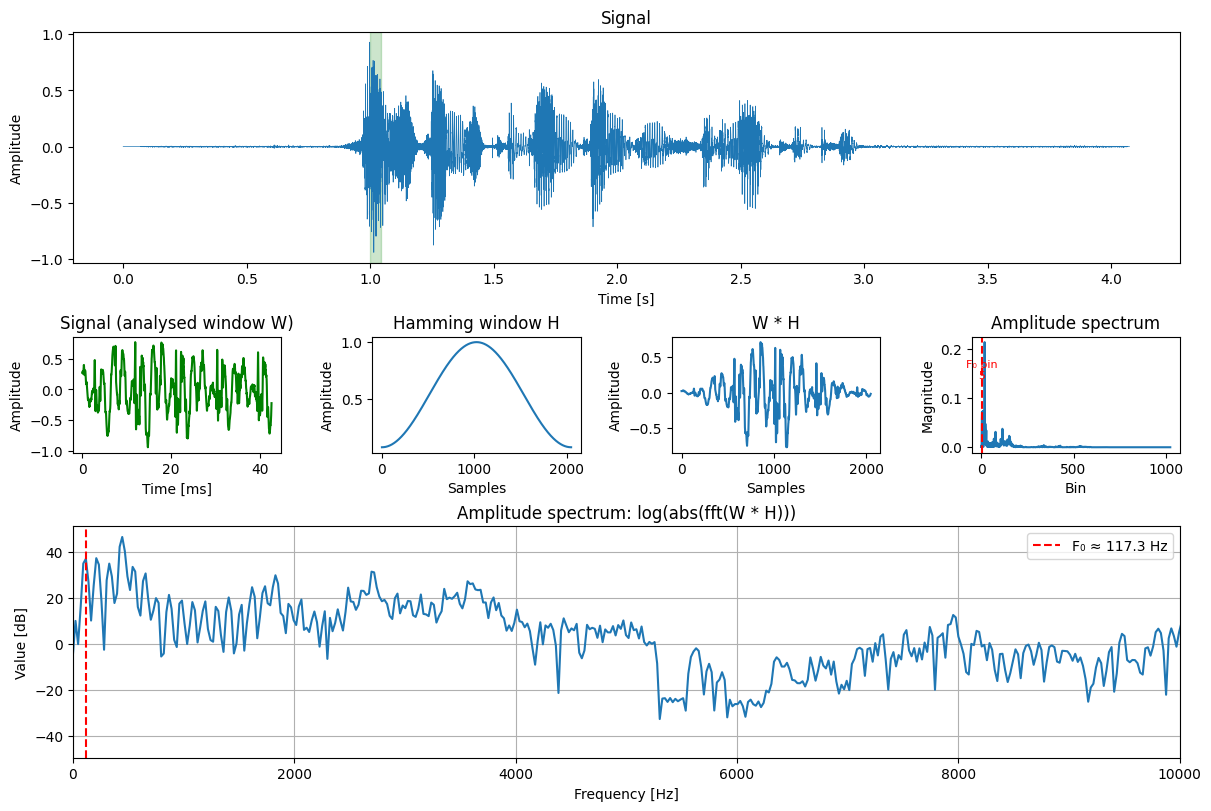

Odczytane FO: 93.84 Hz


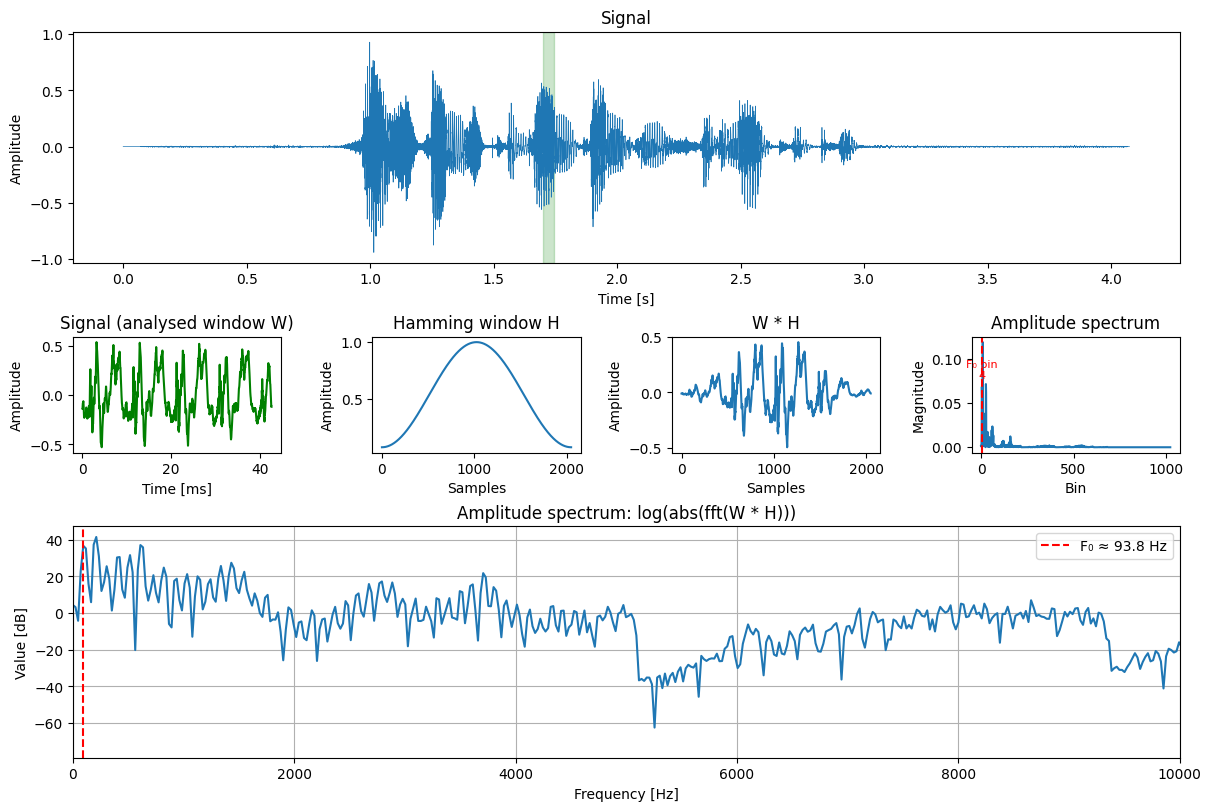

Odczytane FO: 117.30 Hz


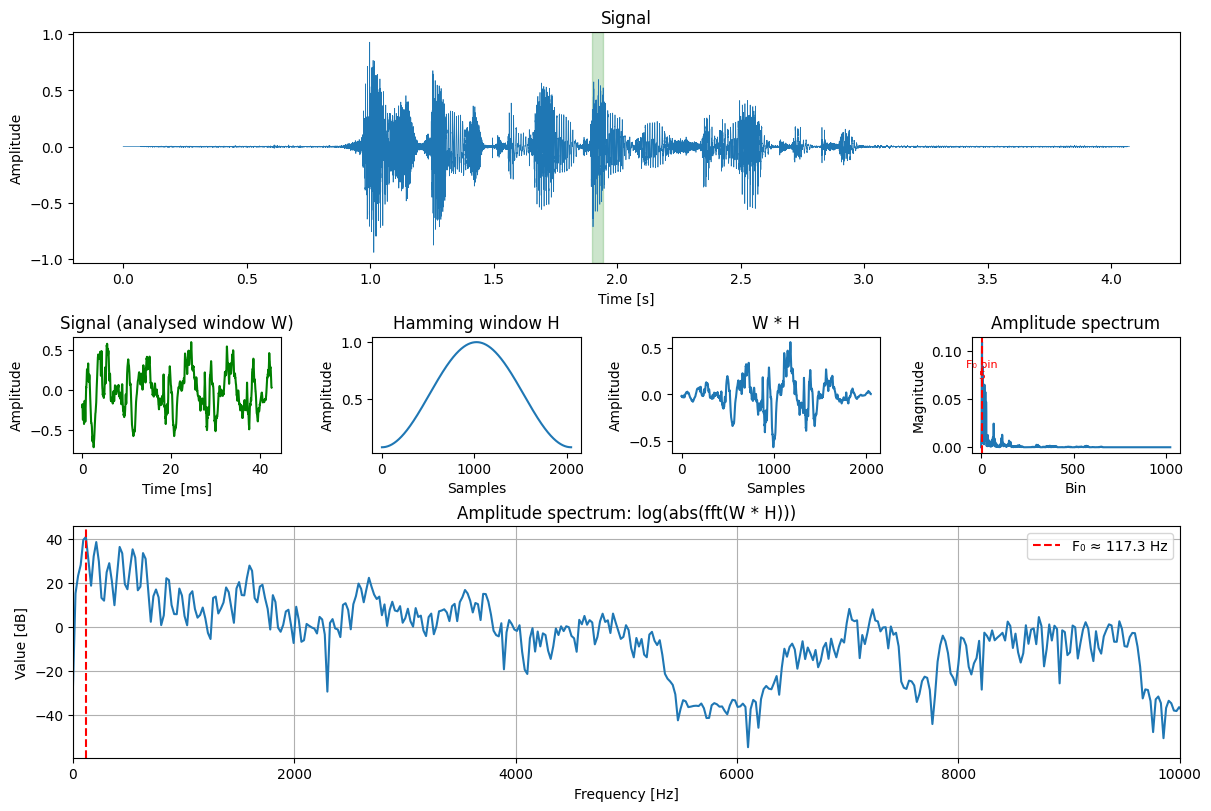

Odczytane FO: 140.76 Hz


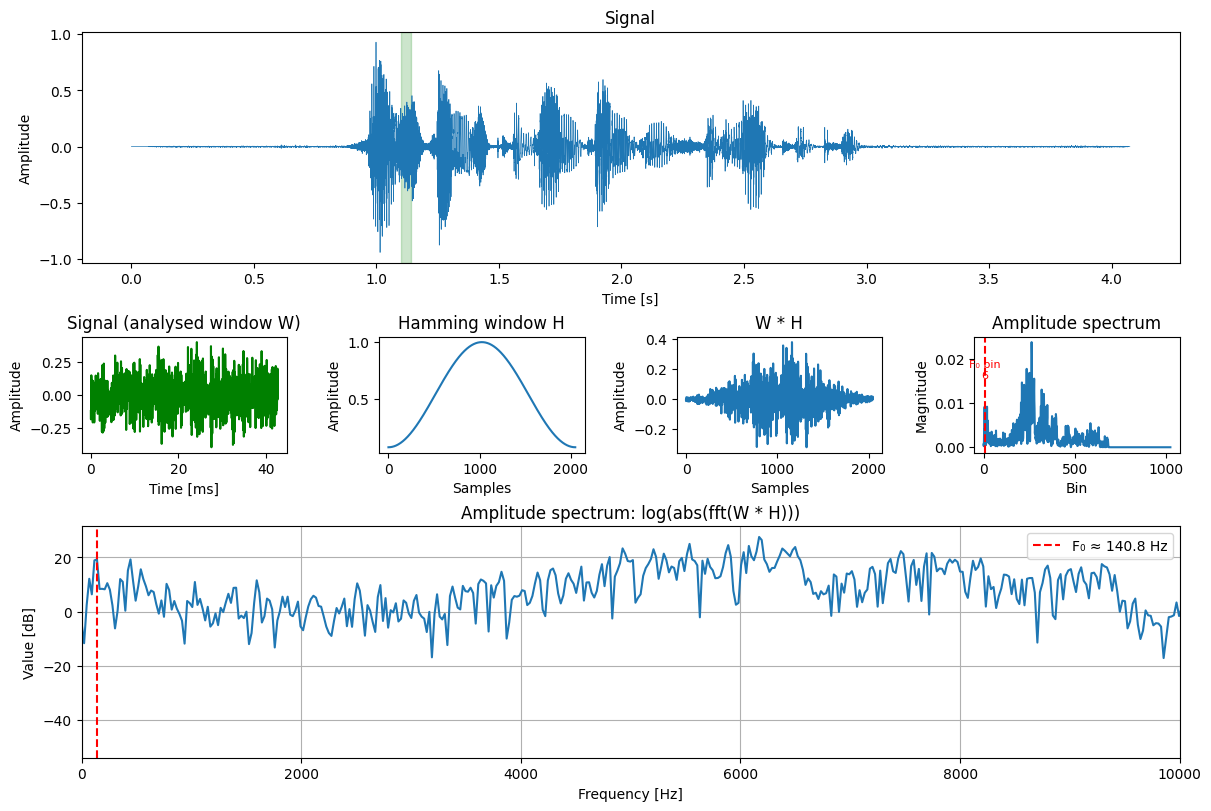

In [170]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.fft import fft

s, fs = sf.read(file_path, dtype='float32')
if s.ndim > 1:
    s = s[:, 0]

fragment_start_sec = 1.0
fragment_len = 2048
def plot_s(s, fs, fragment_start_sec, fragment_len):
    start_sample = int(fragment_start_sec * fs)
    fragment = s[start_sample : start_sample + fragment_len]

    window = np.hamming(fragment_len)
    windowed = fragment * window

    yf = fft(windowed)
    half = fragment_len // 2
    magnitude = np.abs(yf[:half])
    log_magnitude = 20 * np.log10(magnitude + 1e-12)
    freqs = np.linspace(0, fs/2, half)

    min_idx      = np.searchsorted(freqs, 50)
    peaks, _     = find_peaks(magnitude[min_idx:], height=np.max(magnitude)/10)
    if peaks.size:
        peak_idx = peaks[0] + min_idx
        F0       = freqs[peak_idx]
    else:
        F0 = None

    time_full = np.arange(len(s)) / fs
    time_fragment = np.arange(fragment_len) / fs * 1000

    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(3, 4, figure=fig, height_ratios=[2, 1, 2])

    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_full, s, linewidth=0.5)
    ax1.set_title("Signal")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Amplitude")
    ax1.axvspan(fragment_start_sec, fragment_start_sec + fragment_len/fs, color='green', alpha=0.2)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(time_fragment, fragment, color='green')
    ax2.set_title("Signal (analysed window W)")
    ax2.set_xlabel("Time [ms]")
    ax2.set_ylabel("Amplitude")

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(np.arange(fragment_len), window)
    ax3.set_title("Hamming window H")
    ax3.set_xlabel("Samples")
    ax3.set_ylabel("Amplitude")

    ax4 = fig.add_subplot(gs[1, 2])
    ax4.plot(np.arange(fragment_len), windowed)
    ax4.set_title("W * H")
    ax4.set_xlabel("Samples")
    ax4.set_ylabel("Amplitude")

    ax5 = fig.add_subplot(gs[1, 3])
    ax5.plot(magnitude * 1e-3)
    if F0 is not None:
        ax5.axvline(peak_idx, color='red', linestyle='--')
        ax5.text(peak_idx, ax5.get_ylim()[1]*0.8,
                 f"F₀ bin\n{peak_idx}", color='red',
                 ha='center', va='top', fontsize=8)
    ax5.set(title="Amplitude spectrum",
            xlabel="Bin", ylabel="Magnitude")


    ax6 = fig.add_subplot(gs[2, :])
    ax6.plot(freqs, log_magnitude)
    if F0 is not None:
        ax6.axvline(F0, color='red', linestyle='--', label=f"F₀ ≈ {F0:.1f} Hz")
        ax6.legend(loc='upper right')
        print(f"Odczytane FO: {F0:.2f} Hz")
    else:
        print("Nie wykryto wyraźnych szczytów do wyznaczenia F₀.")

    ax6.set(title="Amplitude spectrum: log(abs(fft(W * H)))",
            xlabel="Frequency [Hz]", ylabel="Value [dB]")
    ax6.set_xlim(0, 10000)
    ax6.grid(True)

    plt.show()

plot_s(s, fs, fragment_start_sec, fragment_len)
plot_s(s,fs,1.7,fragment_len)
plot_s(s,fs,1.9,fragment_len)
plot_s(s,fs,1.1,fragment_len)


Wyryte piki formantów w obwiedni LPC:
   282 Hz: 57.6 dB
   3730 Hz: 35.7 dB
   7742 Hz: 26.1 dB
   8751 Hz: 27.6 dB
   10792 Hz: 17.1 dB
   12692 Hz: 27.7 dB
   13959 Hz: 17.3 dB
   15038 Hz: 4.8 dB
   15906 Hz: 16.4 dB


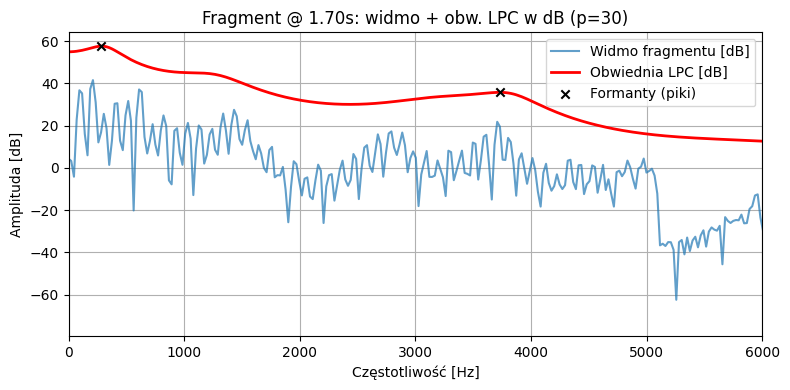

In [171]:
# %% Komórka 4b: plot_v_db z detekcją pików w obwiedni LPC
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
import librosa

def plot_v_db(s, fs, fragment_start_sec, fragment_len=2048, order=30, peak_height_db=-40, peak_distance_hz=100):

    start = int(fragment_start_sec * fs)
    fragment = s[start:start+fragment_len]
    window = np.hamming(fragment_len)
    windowed = fragment * window

    a = librosa.lpc(windowed, order=order)
    a_padded = np.concatenate([a, np.zeros(fragment_len - len(a))])
    Y = fft(windowed)
    H = fft(a_padded)

    half = fragment_len // 2
    freqs = np.linspace(0, fs/2, half)
    mag_db = 20 * np.log10(np.abs(Y[:half]) + 1e-12)
    env_db = -20 * np.log10(np.abs(H[:half]) + 1e-12)

    min_dist_samples = int((peak_distance_hz / (fs/2)) * (half))
    peaks, properties = find_peaks(env_db,
                                   height=peak_height_db,
                                   distance=min_dist_samples)

    peak_freqs = freqs[peaks]
    peak_vals  = env_db[peaks]
    print("Wyryte piki formantów w obwiedni LPC:")
    for f, v in zip(peak_freqs, peak_vals):
        print(f"   {f:.0f} Hz: {v:.1f} dB")

    plt.figure(figsize=(8,4))
    plt.plot(freqs, mag_db, label="Widmo fragmentu [dB]", alpha=0.7)
    plt.plot(freqs, env_db, color="red", linewidth=2, label="Obwiednia LPC [dB]")
    plt.scatter(peak_freqs, peak_vals, color='black', marker='x', zorder=5,
                label="Formanty (piki)")
    plt.title(f"Fragment @ {fragment_start_sec:.2f}s: widmo + obw. LPC w dB (p={order})")
    plt.xlabel("Częstotliwość [Hz]")
    plt.ylabel("Amplituda [dB]")
    plt.xlim(0, 6000)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return a

coefs_db = plot_v_db(s, fs, fragment_start_sec=1.7)


Zadanie 6: ekstrakcja F1 i F2
Fragment 1.00s -> F1 = 422 Hz,  F2 = 2721 Hz
Wyryte piki formantów w obwiedni LPC:
   422 Hz: 64.7 dB
   2557 Hz: 45.0 dB
   3543 Hz: 45.5 dB
   7812 Hz: 30.0 dB
   9947 Hz: 29.9 dB
   12692 Hz: 25.4 dB
   13607 Hz: 19.8 dB
   15765 Hz: 7.7 dB


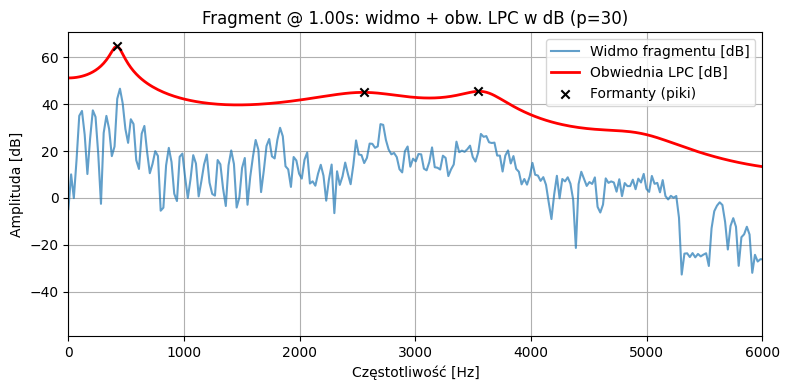

Fragment 1.25s -> F1 = 469 Hz,  F2 = 3589 Hz
Wyryte piki formantów w obwiedni LPC:
   469 Hz: 57.9 dB
   3613 Hz: 42.3 dB
   7226 Hz: 18.7 dB
   8798 Hz: 23.0 dB
   9548 Hz: 21.3 dB
   12997 Hz: 21.4 dB
   13584 Hz: 23.9 dB
   15226 Hz: -3.3 dB
   19214 Hz: -38.0 dB


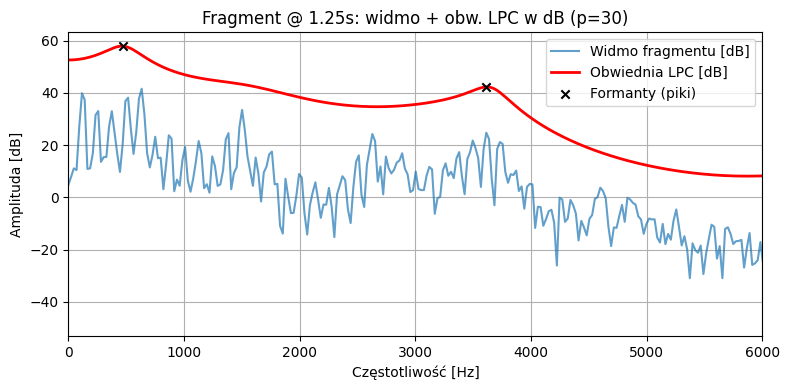

In [ ]:
import numpy as np
import librosa
from scipy.signal import find_peaks
from scipy.fft import fft

def extract_formants(s, fs,fragment_start_sec,fragment_len=2048,order=20,formant_count=2,min_freq=100,max_freq=6000):
    start    = int(fragment_start_sec * fs)
    segment  = s[start:start+fragment_len] * np.hamming(fragment_len)
    a        = librosa.lpc(segment, order=order)
    a_pad    = np.concatenate([a, np.zeros(fragment_len - len(a))])
    env      = -np.log(np.abs(fft(a_pad)[:fragment_len//2]) + 1e-12)
    freqs    = np.linspace(0, fs/2, fragment_len//2)
    mask     = (freqs >= min_freq) & (freqs <= max_freq)
    freq_m   = freqs[mask]
    env_m    = env[mask]
    peaks, _ = find_peaks(env_m, distance=5)
    if len(peaks) >= formant_count:
        idx = np.argsort(freq_m[peaks])[:formant_count]
        formants = freq_m[peaks][idx]
    else:
        amps = env_m[peaks]
        idx  = np.argsort(amps)[-formant_count:]
        formants = np.sort(freq_m[peaks][idx])
    return formants

times = [1.00, 1.25]

print("Zadanie 6: ekstrakcja F1 i F2")
for t in times:
    F = extract_formants(s, fs, t)
    if F.size >= 2:
        print(f"Fragment {t:.2f}s -> F1 = {F[0]:.0f} Hz,  F2 = {F[1]:.0f} Hz")
        plot_v_db(s, fs, fragment_start_sec=t)

print("fragment 1 = i")
print('fragment 2 = i')